In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(33, num_classes)
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input ==> ", x.size())
        out = F.relu(self.bn1(self.conv1(x)))
        # print("F.relu(self.bn1(self.conv1(x))) ==> ", x.size())
        out = self.layer1(out)
        # print("layer1 ==> ", x.size())
        out = self.layer2(out)
        # print("layer2 ==> ", x.size())
        out = self.layer3(out)
        # print("layer3 ==> ", x.size())
        out = self.layer4(out)
        # print("layer4 ==>", out.size())
        out = F.avg_pool2d(out, (2,3))
        # print("avg_pool2d ===>", out.size())
        # out = out.view(out.size(0), -1)
        # print("out.view ===>", out.size())
        out = self.linear(out)
        out = self.flat(out)
        # print("Out ===>", out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 8, 100)
    model = ResNet18()
    model(image)


In [ ]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm

# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof

In [ ]:
train_dataset_list = []
test_dataset_list = []

In [ ]:
df1  = sio.loadmat("/content/drive/MyDrive/DOA/DOA5/SNR_NS_0_5_100000.mat")
df2  = sio.loadmat("/content/drive/MyDrive/DOA/DOA5/SNR_NS_10_5_100000.mat")
df3  = sio.loadmat("/content/drive/MyDrive/DOA/DOA5/SNR_NS_20_5_100000.mat")
df4  = sio.loadmat("/content/drive/MyDrive/DOA/DOA5/SNR_NS_30_5_100000.mat")
df5  = sio.loadmat("/content/drive/MyDrive/DOA/DOA5/SNR_NS_40_5_100000.mat")
df = [df1, df2, df3, df4, df5]
# getsizeof(df)

In [ ]:
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []

In [ ]:
def create_dataset(df):
    data = np.transpose(df['NS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())

In [ ]:
for file in df:
    create_dataset(file)

In [ ]:
del df
del df1
del df2
del df3
del df4
del df5

In [ ]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 100))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new

In [ ]:
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 100))
        for j in range(0, 8):
            for k in range(0, 100):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [ ]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample

    dataset = DOA_dataset(train, test)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [ ]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [ ]:
del new_train_dataset_list
del train_dataset_list_label

In [ ]:
test_dataset_list = []

In [ ]:
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [ ]:
del new_test_dataset_list
del new

In [ ]:
for i in test_dataset_list:
  for a, (features, labels) in enumerate(i):
    features, labels = Variable(features.cuda()), Variable(labels.cuda())
    print(labels[11])
    break

tensor([ 62, 153, 151,  19, 137], device='cuda:0')
tensor([141,  81, 102,   2, 115], device='cuda:0')
tensor([120,  43,  34, 139, 109], device='cuda:0')
tensor([ 82, 103, 133, 174, 126], device='cuda:0')
tensor([ 85, 141,  51, 166,  59], device='cuda:0')


In [ ]:
num_epochs = 50
doa = 5
weights_dir = "/content/drive/MyDrive/DOA/doa_weights/"

autoencoder = ResNet18()
criterion = nn.CrossEntropyLoss()
if ('DOA_{}_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
    print("Pre-trained available for DOA_{}_model.pth".format(doa))
    autoencoder = torch.load(os.path.join(weights_dir, 'DOA_{}_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.001, weight_decay=1e-5)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


In [ ]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 5))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total))))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 5))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total))))

                total_valdation_loss+=validation_loss

            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( model, "/content/drive/MyDrive/DOA/doa_weights/DOA_{}_model.pth".format(doa))
        if i%10 == 0:
          ddf = pd.DataFrame(acc_res)
          ddf.to_csv("/content/drive/MyDrive/DOA/doa_weights/res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 3.9560, Training Accuracy: 5.4540
SNR [0dB], Validation Loss: 4.0266, Validation Accuracy: 5.2093
SNR [10dB], Validation Loss: 3.2813, Validation Accuracy: 9.4560
SNR [20dB], Validation Loss: 3.0407, Validation Accuracy: 11.2453
SNR [30dB], Validation Loss: 3.0046, Validation Accuracy: 11.4320
SNR [40dB], Validation Loss: 2.9993, Validation Accuracy: 11.2467


Epoch [2/50], Training Loss: 2.9470, Training Accuracy: 13.6136
SNR [0dB], Validation Loss: 3.7188, Validation Accuracy: 7.9867
SNR [10dB], Validation Loss: 2.8505, Validation Accuracy: 14.9573
SNR [20dB], Validation Loss: 2.5453, Validation Accuracy: 18.4440
SNR [30dB], Validation Loss: 2.4926, Validation Accuracy: 18.9280
SNR [40dB], Validation Loss: 2.4800, Validation Accuracy: 19.0507


Epoch [3/50], Training Loss: 2.5703, Training Accuracy: 19.3179
SNR [0dB], Validation Loss: 3.4705, Validation Accuracy: 10.0240
SNR [10dB], Validation Loss: 2.5112, Validation Accuracy: 19.

KeyboardInterrupt: ignored

In [ ]:
epc_list = range(0, 30)

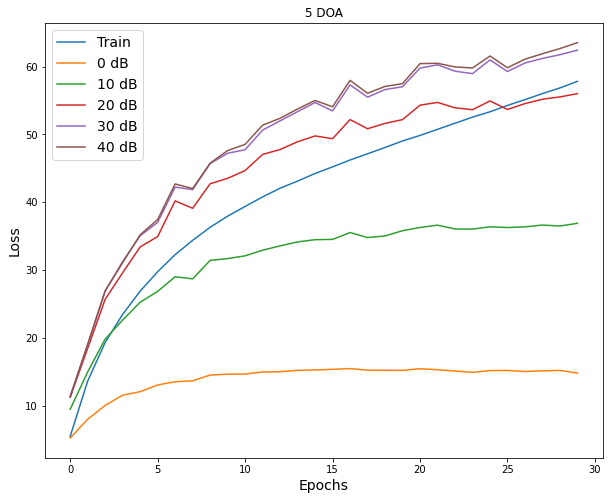

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(epc_list, acc_res["training"], label='Train')
plt.plot(epc_list, acc_res[0], label='0 dB')
plt.plot(epc_list, acc_res[10], label='10 dB')
plt.plot(epc_list, acc_res[20], label='20 dB')
plt.plot(epc_list, acc_res[30], label='30 dB')
plt.plot(epc_list, acc_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("5 DOA")
plt.legend(fontsize=14)
plt.show()



In [9]:
import torch
import torch.nn as nn
from torch.nn import init

def single_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,2),stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3,3),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,3), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv


def up_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2, 2), stride=2))
    return conv
    
def up_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=(2,2), stride=2))
    return conv


class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



class Att_R2U(nn.Module):
    def __init__(self,img_ch=1,output_ch=1,t=2):
        super(Att_R2U, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.RCNN1 = RRCNN_block(img_ch, 64, t=t)
        self.RCNN2 = RRCNN_block(64, 128, t=t)
        self.RCNN3 = RRCNN_block(128, 256, t=t)

        self.up_trans_1 = up_conv1(256, 128)
        self.Att1 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN1 = RRCNN_block(256, 128,t=t)
        
        self.up_trans_2 = up_conv2(128, 64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(128, 64,t=t)
        self.linear = nn.Linear(25, 181)
        self.dropout1 = nn.Dropout(0.6)
        self.dropout2 = nn.Dropout(0.4)
        self.adp_pool = nn.AdaptiveMaxPool2d((4, 25))
        self.flat = nn.Conv2d(
            in_channels=256,
            out_channels=output_ch,
            kernel_size=1,stride=1,padding=0)

    def forward(self, image):
        # encoder
        x1 = self.RCNN1(image)
        # print("Conv3x2, S1, P1        => ", x1.size())
        x2 = self.max_pool_2x2(x1)
        # print("max_pool_2x1           => ", x2.size())
        x3 = self.RCNN2(x2)
        # print("Conv3x3, S1, P1        => ", x3.size())
        x4 = self.max_pool_2x2(x3)
        # print("max_pool_2x1           => ", x4.size())
        x5 = self.RCNN3(x4)
        out = self.dropout1(x5)
        # print("Conv3x3, S1, P1        => ", x5.size())
        out = self.adp_pool(out)
        out = self.linear(out)
        out = self.dropout2(out)
        return self.flat(out)




if __name__ == "__main__":
    print("start")
    image = torch.rand(1, 1, 8, 40)
    model = Att_R2U()
    print(model(image).size())

start
torch.Size([1, 1, 4, 181])
